In [1]:
from VLA2Systems.task_data_generator import TaskDataGenerator
env_dict = {
    "easy": [
        "BabyAI-OneRoomS8-v0",
        "BabyAI-PutNextLocal-v0",
        "BabyAI-PickupDist-v0",
        "BabyAI-GoToRedBallGrey-v0",
        "BabyAI-GoToRedBall-v0"
    ],
    "intermediate": ["BabyAI-FindObjS5-v0"],
    "hard": ["BabyAI-UnlockToUnlock-v0", "BabyAI-Synth-v0"]
}

index = 0
generator = TaskDataGenerator(env_dict)
generator.reset(difficulty="easy")  # Select from "hard" list
env = generator.env
# model = EarlyFusionTransformerACModel()

Sampling rejected: objs already next to each other


In [2]:
from minigrid.core.actions import Actions

obs, reward, done, truncated, info = env.step(Actions.toggle)
env.observation_space.spaces['image']

Box(0, 255, (7, 7, 3), uint8)

In [3]:
import yaml
class ConfigParser:
    def __init__(self, config_path="config.yaml"):
        with open(config_path, "r") as file:
            self.config = yaml.safe_load(file)
        self.model = self.get("model")
    def get(self, key, default=None):
        return self.config.get(key, default)


In [4]:
config = ConfigParser("./configs/model.yaml")

config.model

{'batch_size': 256,
 'patch_size': 4,
 'embed_dim': 64,
 'num_heads': 2,
 'num_layers': 2,
 'use_text': False,
 'vocab_size': 100,
 'text_embed_dim': 32,
 'max_text_len': 20}

In [5]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence embedding model (e.g., 'all-MiniLM-L6-v2' is small and fast)
text_encoder = SentenceTransformer("all-MiniLM-L6-v2")

import numpy as np
def obs2enc(obs):
    enc_image = np.zeros((8, 7, 7), dtype=np.float16)
    im = obs["image"].astype(np.int8)
    im = np.permute_dims(im, (2, 0, 1))
    enc_image[0] = im[0]%2
    enc_image[1] = im[0]/2%2
    enc_image[2] = im[0]/4%2
    enc_image[3] = im[1]%2
    enc_image[4] = im[1]/2%2
    enc_image[5] = im[1]/4%2
    enc_image[6] = im[2]%2
    enc_image[7] = im[2]/2%2
    enc_image = np.permute_dims(enc_image, (1, 2, 0))
    enc_image = enc_image.astype(np.int8)
    return enc_image


/var/lit2425/jenga/mmfm_project/Baby-AI-S2-S1-VLA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sampling rejected: objs already next to each other


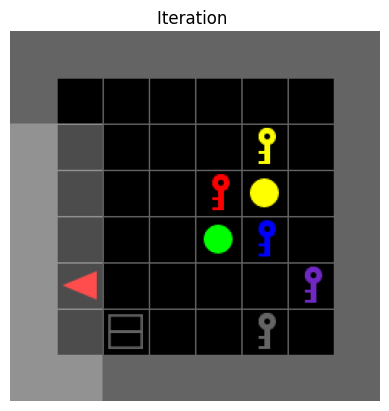

Sentence: put the green ball next to the grey box
Sentence Embedding Shape: (384,)
Image Encoding Shape: (7, 7, 8)


In [6]:
generator.reset(difficulty="easy")  # Select from "hard" list
obs, reward, done, truncated, info = generator.env.step(Actions.toggle)
generator.visualize()
# Example text
# Generate the sentence embedding
embedding = text_encoder.encode(obs["mission"])
im_enc = obs2enc(obs)

# Print the embedding (a vector)
print("Sentence:", obs["mission"])
print("Sentence Embedding Shape:", embedding.shape)
print("Image Encoding Shape:", im_enc.shape)
# print("Embedding:", embedding)

In [7]:
generator.env.observation_space.spaces['mission']


MissionSpace(<function BabyAIMissionSpace._gen_mission at 0x7f812c284f70>, None)

In [8]:
%reload_ext autoreload
%autoreload 2
from VLA2Systems.custom_ppo import SimpleVLA

model = SimpleVLA(env.observation_space, 
                  embedding_size=128, 
                  sentence_embedding_size=384)


/var/lit2425/jenga/mmfm_project/Baby-AI-S2-S1-VLA/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [9]:
from VLA2Systems.custom_ppo import CustomEnvWrapper

env = CustomEnvWrapper(generator.env, text_encoder)

In [10]:
obs, reward, done, truncated, info = env.step(Actions.toggle)


In [11]:
obs['mission']

tensor([ 8.1790e-02,  1.0219e-01, -3.2465e-03, -7.2960e-02,  5.2569e-02,
         6.9350e-02,  3.4372e-02,  1.1307e-02,  8.2964e-02,  2.5229e-02,
        -7.0839e-03, -3.0410e-02, -4.6623e-02,  3.0883e-02,  4.8886e-03,
         5.3471e-04, -6.5197e-02, -2.0668e-02, -8.3048e-02, -6.4966e-02,
         2.0878e-03, -3.0212e-02,  3.8251e-03, -9.9660e-02, -1.5371e-01,
         8.4787e-02, -9.2441e-03,  8.9784e-02, -4.6142e-02, -7.4304e-02,
        -2.8430e-02, -9.9148e-02, -3.0772e-03,  6.7861e-02, -7.1111e-02,
        -5.9729e-02, -9.0497e-02,  3.9035e-02,  1.7553e-02, -3.7210e-03,
        -2.7656e-02, -5.6246e-02,  2.7779e-02,  7.2737e-02, -4.8032e-02,
         4.0156e-02,  1.2213e-02, -3.5112e-02,  1.0571e-01, -4.8600e-02,
        -2.6139e-03, -4.2250e-02,  1.6341e-02,  7.1464e-02,  5.3758e-02,
         7.9051e-02,  1.6382e-02, -3.2311e-02,  1.8773e-02, -5.3428e-02,
         6.6321e-02,  4.0219e-02,  2.5511e-03, -1.8773e-02,  1.9028e-02,
         7.4061e-03, -4.4651e-02, -4.0652e-03, -7.1

In [12]:
obs['image'].shape

torch.Size([7, 7, 8])

In [14]:
import torch
from stable_baselines3 import PPO

# Load the saved PPO model
model = PPO.load("ppo_transformer_agent")

# Access the underlying policy network.
# Note: model.policy is an instance of ActorCriticPolicy.
policy_net = model.policy

# Prepare an observation (this must match your environment's observation structure)
obs = env.reset()[0]

# Convert observation to the appropriate tensor(s)
# For instance, if your observation is a dictionary with "image" and "mission":

obs_tensor = {
    'image': torch.tensor(obs['image'], dtype=torch.float32).unsqueeze(0),
    'mission': torch.tensor(obs['mission'], dtype=torch.float32).unsqueeze(0)
}

# Pass the observation through the feature extractor and the policy MLP
# The policy's forward method in Stable-Baselines3 returns a distribution and value.
with torch.no_grad():
    output = policy_net.forward(obs_tensor)

print(output)
# Get action logits from the distribution and select the highest-probability action.
# action_tensor = torch.argmax(distribution.distribution.logits, dim=1)
action = output[0].item()
print(action)

# Use the action with your environment
obs, reward, done, truncated, info = env.step(action)
image = env.render()
print(image.shape)

Entered forward
(tensor([3], device='cuda:0'), tensor([[-0.3002]], device='cuda:0'), tensor([-1.8359], device='cuda:0'))
3
(256, 256, 3)


/tmp/ipykernel_506679/904828811.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(obs['image'], dtype=torch.float32).unsqueeze(0),
/tmp/ipykernel_506679/904828811.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mission': torch.tensor(obs['mission'], dtype=torch.float32).unsqueeze(0)


In [18]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def show_frame(image):
    """
    Displays a single frame in a Jupyter Notebook.
    
    :param image: The image to display (e.g., from env.render()).
    """
    clear_output(wait=True)  # Clear previous output
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    display(plt.gcf())  # Show figure

KeyboardInterrupt: 

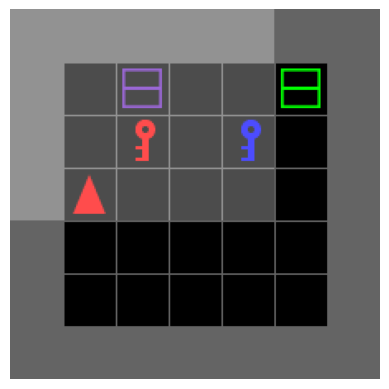

In [24]:
generator.reset(difficulty="easy")
env = CustomEnvWrapper(generator.env, text_encoder)
obs = env.reset()[0]

model = PPO.load("ppo_transformer_agent")

# Access the underlying policy network.
# Note: model.policy is an instance of ActorCriticPolicy.
policy_net = model.policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# obs_mission = env.unwrapped.reset()[0]
# Example of updating the display manually
print(obs['mission'])
for _ in range(100):  

    obs_tensor = {
        'image': torch.tensor(obs['image'], dtype=torch.float32).unsqueeze(0).to(device),
        'mission': torch.tensor(obs['mission'], dtype=torch.float32).unsqueeze(0).to(device)
    }

    with torch.no_grad():
        output = policy_net.forward(obs_tensor)

    action = output[0].item()

    # Use the action with your environment
    obs, reward, done, truncated, info = env.step(action)
    image = env.render()
    print(env.mission)
    show_frame(image)  # Update the display